## Problem Statement

This is a project about training an RNN (LSTM) model **to classify tweets into two categories** : ones that are talking about real disasters, and ones that are not.

According to the competition description, the dataset was created by the company figure-eight, and the categories were hand-classified by human.

Inside the input directory, I see one train data and test data each in a format of .csv, plus a sample submission.

I will use **Keras** library to create / import some models, and optimize & evaluate the model parameters to finalize the submission output.

## Environment Setup & Basic EDA & Data Cleaning

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from wordcloud import WordCloud
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
import numpy as np
from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


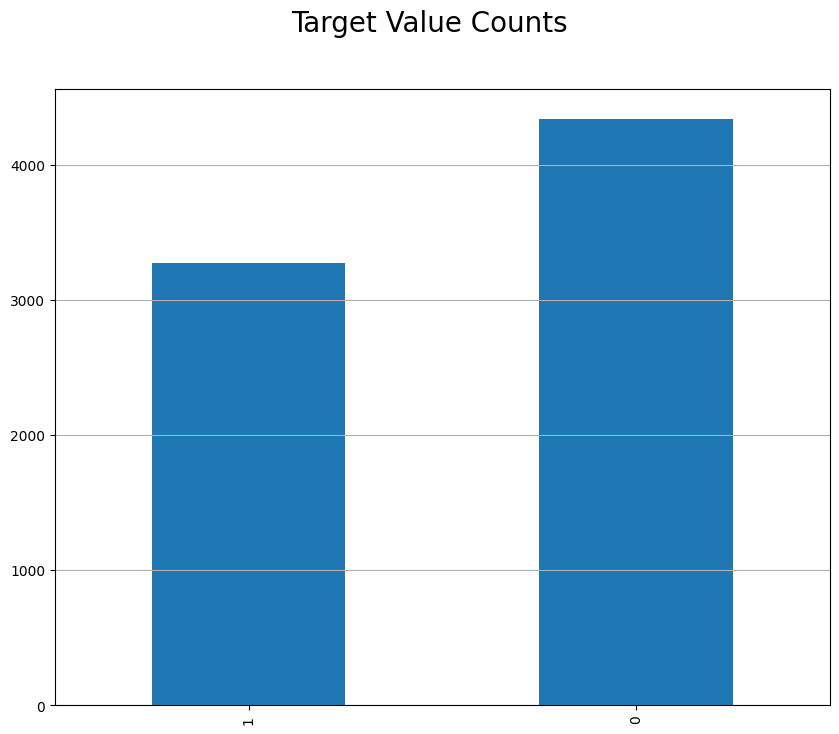

In [3]:
plt.figure(figsize=(10,8))
ax = train_data['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()

In [4]:
print("Number of missing data for column keyword: ", train_data['keyword'].isna().sum())
print("Number of missing data for column location: ", train_data['location'].isna().sum())
print("Number of missing data for column text: ", train_data['text'].isna().sum())
print("Number of missing data for column target: ", train_data['target'].isna().sum())

Number of missing data for column keyword:  61
Number of missing data for column location:  2533
Number of missing data for column text:  0
Number of missing data for column target:  0


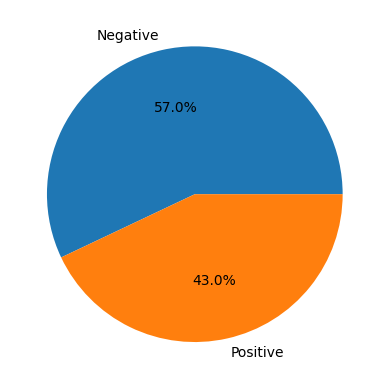

In [5]:
label_count = train_data['target'].value_counts()
labels = ['Negative', 'Positive']

plt.pie(label_count, labels=labels, autopct='%1.1f%%')
plt.show()

In [6]:
print(label_count[0]/label_count[1])

1.3274228064811984


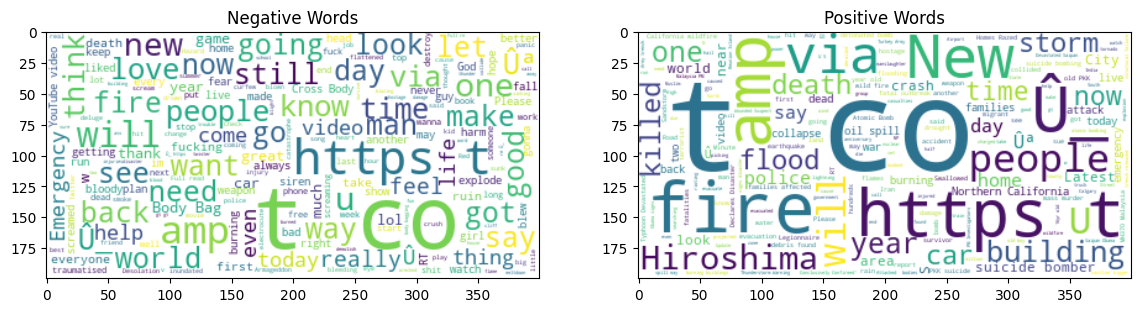

In [7]:
negative_cases = "".join(train_data[train_data['target'] == 0]['text'].values)
positive_cases = "".join(train_data[train_data['target'] == 1]['text'].values)

fig, axis = plt.subplots(1, 2, figsize=(14, 8))

cl1 = WordCloud(background_color='white').generate(negative_cases)
cl2 = WordCloud(background_color='white').generate(positive_cases)

axis[0].imshow(cl1, interpolation='bilinear')
axis[0].set_title('Negative Words')
axis[1].imshow(cl2, interpolation='bilinear')
axis[1].set_title('Positive Words')
plt.show()

In [25]:
path_to_glove_file = 'glove.6B.300d.txt'
embedding_dim = 300
learning_rate = 1e-3
batch_size = 1024
epochs = 20
sequence_len = 100

In [18]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

nltk.download('punkt')
def clean_text(each_text):

    each_text_no_url = re.sub(r"http\S+", "", each_text)
    
    text_no_num = re.sub(r'\d+', '', each_text_no_url)

    word_tokens = word_tokenize(text_no_num)
    
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
    
    return " ".join(" ".join(stemmed_text).split())


train_data['clean_text'] = train_data['text'].apply(lambda x: clean_text(x) )
train_data['keyword'] = train_data['keyword'].fillna("none")
train_data['clean_keyword'] = train_data['keyword'].apply(lambda x: clean_text(x) )

In [19]:
feature = 'keyword_text'
label = "target"
train_data['keyword_text'] = train_data['clean_keyword'] + " " + train_data["clean_text"]
X_train, X_test,y_train, y_test = model_selection.train_test_split(train_data[feature],
                                                                   train_data[label],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)

In [20]:
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

print("Training Y shape:", y_train_LSTM.shape)
print("Testing Y shape:", y_test_LSTM.shape)

Training Y shape: (5329, 1)
Testing Y shape: (2284, 1)


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  11271


In [22]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=sequence_len)

print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_test.shape)

Training X shape:  (5329, 100)
Testing X shape:  (2284, 100)


In [28]:
import codecs
embeddings_index = {}
types_of_encoding = ["utf8"]
for encoding_type in types_of_encoding:
    with codecs.open(path_to_glove_file, encoding=encoding_type) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [29]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)

## Model

In [30]:
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          3381300   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [31]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/20
6/6 [==============================] - 210s 26s/step - loss: 0.6630 - accuracy: 0.5939 - val_loss: 0.5499 - val_accuracy: 0.7461
Epoch 2/20
6/6 [==============================] - 158s 26s/step - loss: 0.5486 - accuracy: 0.7470 - val_loss: 0.5289 - val_accuracy: 0.7526
Epoch 3/20
6/6 [==============================] - 178s 29s/step - loss: 0.4957 - accuracy: 0.7737 - val_loss: 0.4984 - val_accuracy: 0.7798
Epoch 4/20
6/6 [==============================] - 189s 31s/step - loss: 0.4702 - accuracy: 0.7878 - val_loss: 0.4979 - val_accuracy: 0.7763
Epoch 5/20
6/6 [==============================] - 212s 35s/step - loss: 0.4532 - accuracy: 0.7962 - val_loss: 0.4791 - val_accuracy: 0.7793
Epoch 6/20
6/6 [==============================] - 263s 43s/step - loss: 0.4361 - accuracy: 0.8056 - val_loss: 0.4844 - val_accuracy: 0.7868
Epoch 7/20
6/6 [==============================] - 240s 39s/step - loss: 0.4059 - accuracy: 0.8204 - val_loss: 0.5004 - val_accuracy: 0.7842
Epoch 8/20
6/6 [====

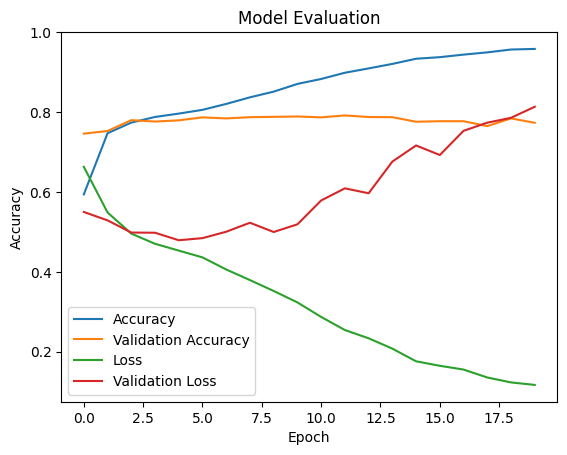

In [33]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

## Evaluation And Prediction

In [34]:
predicted = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)

print("Test Accuracy: ", test_accuracy)

1/1 [==============================] - 4s 4s/step - loss: 0.8133 - accuracy: 0.7732
Test Accuracy:  0.7732049226760864


In [35]:
print(metrics.classification_report(list(y_test), y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1338
           1       0.74      0.69      0.72       946

    accuracy                           0.77      2284
   macro avg       0.77      0.76      0.76      2284
weighted avg       0.77      0.77      0.77      2284



`Our Model Got a Testing accuracy of 77.32%`